Linear Regression Results (with FICO adjustment):
Mean Squared Error: 0.1699
R^2 Score: 0.0980

[Linear Regression] Predicted results for 50 users:
 ORIG BAL Predicted_ChargeOffRate Expected_Recovery
$3,817.80                  41.52%         $2,232.51
$4,053.24                  61.60%         $1,556.52
$4,053.24                  44.09%         $2,266.22
$3,824.64                  40.72%         $2,267.27
$3,535.92                  52.11%         $1,693.20
$2,379.60                  45.25%         $1,302.92
$4,273.56                  60.06%         $1,706.91
$4,053.24                  64.73%         $1,429.70
$4,422.24                  45.34%         $2,417.03
$2,287.80                  43.43%         $1,294.14
$2,971.08                  47.17%         $1,569.61
$4,160.16                  41.24%         $2,444.35
$1,859.04                  39.48%         $1,125.12
$7,290.72                  47.50%         $3,827.91
$3,425.04                  43.56%         $1,932.93
$2,259.36           

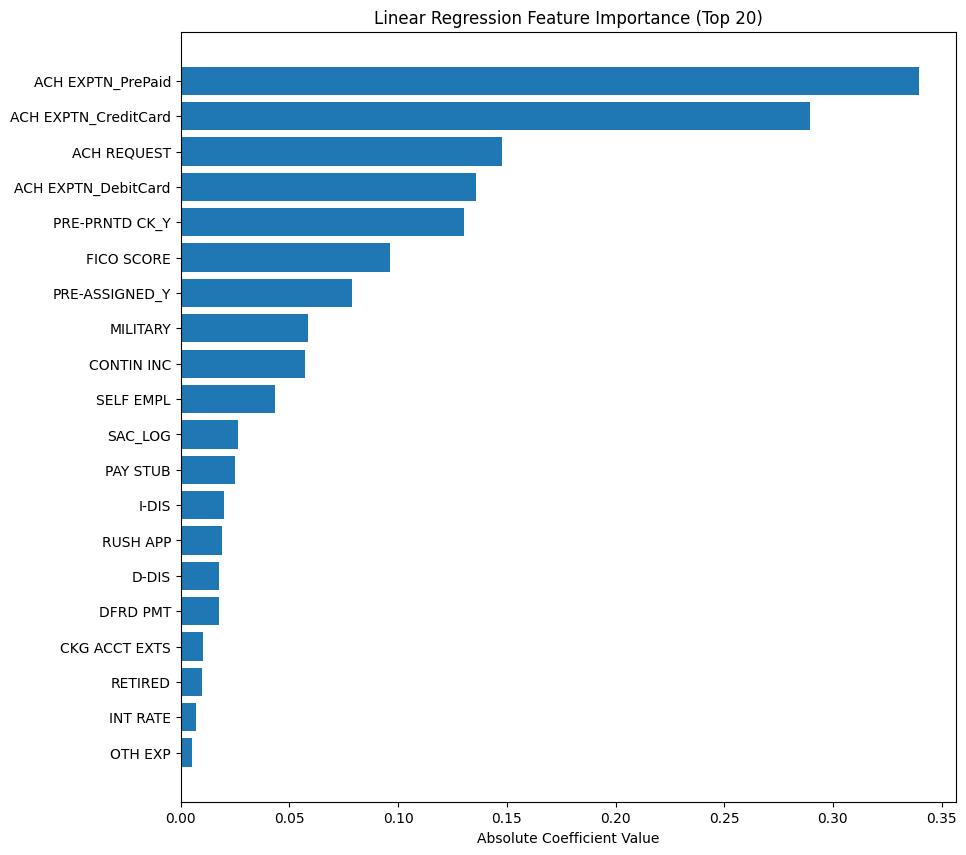

In [14]:
# =========================
# Step 1: Import Libraries
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# =========================
# Step 2: Load Dataset
# =========================

file_path = "/kaggle/input/trkcus-seasonal-adjustment-dataset-20152020/TRKCUS-01012015-02282020-SST ADJ CORRECTED.xlsx"
df = pd.read_excel(file_path)

# =========================
# Step 3: Feature Engineering for Linear Regression
# =========================
df  = df[df["FICO SCORE"] != 1].copy()  
df["FICO_ORIG"] = df["FICO SCORE"]

df["FICO SCORE"] = scaler.fit_transform(df[["FICO SCORE"]])
# 3a. ChargeOffRate
df["ChargeOffRate"] = df["CO AMOUNT"] / df["ORIG BAL"]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ChargeOffRate"])

# 3b. FICO Score


# 3c. Dealer Code (first 4 chars)
df["DEALER CODE"] = df["DEALER CODE"].str[:-1].astype(int)
df = pd.get_dummies(df, columns=["DEALER CODE"], drop_first=True)

# 3d. Boolean features: convert blanks/NaN → N → map to 0/1
binary_cols = [
    "DFRD PMT","SELF EMPL","RETIRED","MILITARY","CB SSN","PAY STUB",
    "RUSH APP","CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP",
    "REFERNCS","SPANISH","#OF ACSORY","I-DIS","D-DIS"
]
for col in binary_cols:
    df[col] = df[col].fillna("N").replace("", "N").map({"Y": 1, "N": 0})

# 3e. Employment & Address (convert yrs+mos → total months)
df["EMPL_TOTAL_MOS"] = df["EMPL_TOTAL_MOS"].clip(0, 600)  # cap 50 years
df["ADDR_TOTAL_MOS"] = df["ADDR_TOTAL_MOS"].clip(0, 360)  # cap 30 years

# 3f. Dates (APP DATE, SIGNED)
for col in ["APP DATE", "SIGNED"]:
    df[col] = df[col].replace("", np.nan)
    df[col] = pd.to_datetime(df[col], format="%Y%m%d", errors="coerce")

# Extract date parts
df["APP_YEAR"] = df["APP DATE"].dt.year.fillna(0).astype(int)
df["APP_MONTH"] = df["APP DATE"].dt.month.fillna(0).astype(int)
df["APP_DAYOFWEEK"] = df["APP DATE"].dt.dayofweek.fillna(0).astype(int)

df["SIGNED_YEAR"] = df["SIGNED"].dt.year.fillna(0).astype(int)
df["SIGNED_MONTH"] = df["SIGNED"].dt.month.fillna(0).astype(int)
df["SIGNED_DAYOFWEEK"] = df["SIGNED"].dt.dayofweek.fillna(0).astype(int)
df["APP_SIGNED_DAYS"] = (df["SIGNED"] - df["APP DATE"]).dt.days.fillna(0)

df = df.drop(columns=["APP DATE","SIGNED"])  # drop raw dates

# 3g. SAC (Same-as-Cash promo)
df["SAC"] = pd.to_numeric(df["SAC"], errors="coerce").fillna(0)
df["SAC_LOG"] = np.log1p(df["SAC"])   # log-transform helps regression
df["SAC"] = scaler.fit_transform(df[["SAC"]])  # scale for regression models

# 3h. PRE-ASSIGNED (blanks → N)
df["PRE-ASSIGNED"] = df["PRE-ASSIGNED"].fillna("N").replace("", "N")

# 3i. PRE-PRNTD CK (P → Y, blanks → N)
df["PRE-PRNTD CK"] = df["PRE-PRNTD CK"].replace("P", "Y").fillna("N").replace("", "N")

# 3j. ACH EXPTN (map codes to categories)
ach_map = {
    "C": "CreditCard",
    "D": "DebitCard",
    "N": "NoException",
    "P": "PrePaid",
    "Y": "ACH_Allowed_NoCheck"
}
df["ACH EXPTN"] = df["ACH EXPTN"].map(ach_map).fillna("NoException")

# One-hot encode PRE-ASSIGN, PRE-PRNTD CK, ACH EXPTN
df = pd.get_dummies(df, columns=["PRE-ASSIGNED","PRE-PRNTD CK","ACH EXPTN"], drop_first=True)

# =========================
# Step 3b: Feature List
# =========================
features = [
    "FICO SCORE","DEALER CODE","CONTRACT TERM","INT RATE","AMT FINAN","DOWN","DFRD PMT",
    "SELF EMPL","EMPL_TOTAL_MOS","ADDR_TOTAL_MOS","AGE","RETIRED","PRODUCT","MILITARY","PAY STUB",
    "SAC_LOG","RUSH APP","ORIG ST","APP_YEAR","APP_MONTH","APP_DAYOFWEEK",
    "CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP","REFERNCS","SPANISH","#OF ACSORY",
    "I-DIS","D-DIS","SIGNED_YEAR","SIGNED_MONTH","SIGNED_DAYOFWEEK","APP_SIGNED_DAYS",
    # replace original with dummies:
    "PRE-ASSIGNED_Y","PRE-PRNTD CK_Y",
    "ACH EXPTN_CreditCard","ACH EXPTN_DebitCard","ACH EXPTN_PrePaid","ACH EXPTN_ACH_Allowed_NoCheck"
]
features = [col for col in features if col in df.columns]

# Convert features → numeric where possible
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.fillna(0)  # final NaN cleanup
X = df[features]
y = df["ChargeOffRate"]

# =========================
# Step 4: Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# Step 5: Linear Regression Model
# =========================
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Evaluate Linear Regression
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression Results (with FICO adjustment):")
print(f"Mean Squared Error: {mse_lin:.4f}")
print(f"R^2 Score: {r2_lin:.4f}")

# =========================
# Step 6: Predictions for Business Cases
# =========================

# --- Case 1: 50 random users ---
sample_50 = df.sample(50, random_state=42).copy()
pred_50_lin = lin_model.predict(sample_50[features])

sample_50["Predicted_ChargeOffRate"] = pred_50_lin
sample_50["Expected_Recovery"] = sample_50["ORIG BAL"] * (1 - sample_50["Predicted_ChargeOffRate"])

# Format results nicely
results_50 = sample_50[["ORIG BAL", "Predicted_ChargeOffRate", "Expected_Recovery"]].copy()
results_50["ORIG BAL"] = results_50["ORIG BAL"].apply(lambda x: f"${x:,.2f}")
results_50["Predicted_ChargeOffRate"] = results_50["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")
results_50["Expected_Recovery"] = results_50["Expected_Recovery"].apply(lambda x: f"${x:,.2f}")

# Display results
print("\n[Linear Regression] Predicted results for 50 users:")
print(results_50.to_string(index=False))

# ---- Totals ----
total_orig_bal = sample_50["ORIG BAL"].sum()
avg_chargeoff_rate = sample_50["Predicted_ChargeOffRate"].mean()   # average instead of sum
total_recovery = sample_50["Expected_Recovery"].sum()

print("\n[Linear Regression] Total results for 50 users:")
print(f"Original Balance: ${total_orig_bal:,.2f}")
print(f"Predicted ChargeOffRate (avg): {avg_chargeoff_rate:.2%}")
print(f"Expected Recovery: ${total_recovery:,.2f}")

# --- Case 2: Single user prediction ---
single_user = df.iloc[[0]]  # take first row as example
single_pred_lin = lin_model.predict(single_user[features])[0]
single_expected_recovery_lin = single_user["ORIG BAL"].values[0] * (1 - single_pred_lin)

print("\n[Linear Regression] Single User Example:")
print(f"single_pred_lin: ${single_pred_lin:,.2f}")
print(f"Original Balance: ${single_user['ORIG BAL'].values[0]:,.2f}")
print(f"Predicted ChargeOffRate: {single_pred_lin:.2%}")
print(f"Expected Recovery: ${single_expected_recovery_lin:,.2f}")

# =========================
# Step 7: Feature Importance (Linear Regression coefficients)
# =========================
lin_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lin_model.coef_
})

# Absolute importance
lin_importance["AbsCoefficient"] = lin_importance["Coefficient"].abs()

# Sort by absolute value
lin_importance = lin_importance.sort_values("AbsCoefficient", ascending=False).reset_index(drop=True)

# Add Rank
lin_importance.index += 1
lin_importance.index.name = "Rank"

# Display top features
print("\nLinear Regression Feature Importance (Top 20 by Coefficient Magnitude):")
print(lin_importance.head(20))

# Plot
plt.figure(figsize=(10, 10))
plt.barh(lin_importance["Feature"][:20], lin_importance["AbsCoefficient"][:20])
plt.xlabel("Absolute Coefficient Value")
plt.title("Linear Regression Feature Importance (Top 20)")
plt.gca().invert_yaxis()
plt.show()


In [15]:
# =========================
# Step 8: Output Predictions on Test Set
# =========================

# Get indices of test set back to original dataframe
test_results = df.loc[X_test.index].copy()

# Add actual + predicted
test_results["Actual_ChargeOffRate"] = y_test
test_results["Predicted_ChargeOffRate"] = y_pred_lin
# Compute Expected Recovery = ORIG BAL * (1 - Predicted_ChargeOffRate)
test_results["Expected_Recovery"] = test_results["ORIG BAL"] * (1 - test_results["Predicted_ChargeOffRate"])


# Optional: format percentages for readability
# test_results["Actual_ChargeOffRate"] = test_results["Actual_ChargeOffRate"].apply(lambda x: f"{x:.2%}")
test_results["Predicted_ChargeOffRate"] = test_results["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")
# test_results.shape
# Show first few rows
test_results.head(10)

# Save to Excel
# output_path = "test_predictions.xlsx"
# test_results.to_excel(output_path, index=False)

# print(f"\n✅ Predictions saved to {output_path}")


,FIRST NAME,LAST NAME,SSN,FICO SCORE,DEALER CODE,STATE,CONTRACT TERM,INT RATE,AMT FINAN,DOWN,...,PRE-ASSIGNED_Y,PRE-PRNTD CK_N,PRE-PRNTD CK_Y,ACH EXPTN_CreditCard,ACH EXPTN_DebitCard,ACH EXPTN_NoException,ACH EXPTN_PrePaid,Actual_ChargeOffRate,Predicted_ChargeOffRate,Expected_Recovery
1996,0.0,0.0,0.0,-1.243885,388,GA,36,21.98,2777.72,0.00,...,False,False,True,False,False,True,False,0.000000,41.52%,2232.506290
3096,0.0,0.0,0.0,-2.014731,343,GA,36,21.98,2948.92,0.00,...,False,True,False,False,False,False,False,0.000000,61.60%,1556.517969
20798,0.0,0.0,0.0,-1.495248,291,GA,36,21.98,2948.92,0.00,...,False,False,True,False,False,True,False,0.694444,44.09%,2266.219247
7806,0.0,0.0,0.0,0.180504,371,KY,36,20.00,2858.82,0.00,...,False,False,True,False,False,True,False,0.000000,40.72%,2267.271850
17758,0.0,0.0,0.0,-0.774674,367,TX,36,21.19,2600.00,285.00,...,False,True,False,False,False,False,False,0.750000,52.11%,1693.198934
5607,0.0,0.0,0.0,0.415110,359,GA,36,22.80,1712.00,0.00,...,False,True,False,False,False,False,False,0.000000,45.25%,1302.922303
8967,0.0,0.0,0.0,-2.467184,343,GA,36,21.98,3109.42,0.00,...,False,False,True,False,False,True,False,0.000000,60.06%,1706.914298
6659,0.0,0.0,0.0,-1.193612,343,GA,36,21.98,2948.92,0.00,...,False,True,False,False,False,False,False,0.000000,64.73%,1429.704719
4147,0.0,0.0,0.0,-0.556827,352,HI,24,21.99,3552.35,100.00,...,False,True,False,False,False,False,False,0.000000,45.34%,2417.028804
4477,0.0,0.0,0.0,0.716745,360,VA,30,24.18,1640.00,12.75,...,False,True,False,False,False,False,False,0.000000,43.43%,1294.135268


In [13]:
test_results.to_excel("linear_regression_test_results.xlsx", index=False)

# Move file to working directory so it appears in Kaggle output
import shutil
shutil.move("linear_regression_test_results.xlsx", "/kaggle/working/linear_regression_test_results.xlsx")

'/kaggle/working/linear_regression_test_results.xlsx'